In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results
from plotting.entropy_map_plots import plot_entropy_map_for_patient
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 3

exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])


exp_mc01_softdice = {3: "20180630_10_26_32_dcnn_mc_f3p01_150KE_lr2e02",
                    2: "20180630_10_27_07_dcnn_mc_f2p01_150KE_lr2e02",
                    1: "20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02",
                    0: "20180629_10_33_08_dcnn_mc_f0p01_150KE_lr2e02"}
exp_mc01_softdice_path = os.path.join(LOG_DIR, exp_mc01_softdice[TEST_FOLD])

exp_mc01_crossent = {3: "20180703_18_15_22_dcnn_mc_f3p01_entrpy_150KE_lr2e02",
                     2: "20180703_18_11_10_dcnn_mc_f2p01_entrpy_150KE_lr2e02",
                     1: "20180703_18_13_51_dcnn_mc_f1p01_entrpy_150KE_lr2e02",
                     0: "20180703_18_09_33_dcnn_mc_f0p01_entrpy_150KE_lr2e02"}
exp_mc01_crossent_path = os.path.join(LOG_DIR, exp_mc01_crossent[TEST_FOLD])

exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_softdice = ExperimentHandler()
exper_hdl_mc01_softdice.load_experiment(exp_mc01_softdice_path, use_logfile=False)
exper_hdl_mc01_softdice.set_root_dir(ROOT_DIR)
exper_hdl_mc01_softdice.set_model_name("MC-dropout soft-dice fold-{} (p={})".format(
                                exper_hdl_mc01_softdice.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_softdice.exper.run_args.drop_prob))
# make sure we correct spelling for softdice to soft-dice, which we use in figures
exper_hdl_mc01_softdice.exper.run_args.loss_function = "soft-dice"
print("Model name: {}".format(exper_hdl_mc01_softdice.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_crossent = ExperimentHandler()
exper_hdl_mc01_crossent.load_experiment(exp_mc01_crossent_path, use_logfile=False)
exper_hdl_mc01_crossent.set_root_dir(ROOT_DIR)
exper_hdl_mc01_crossent.set_model_name("MC-dropout cross-entropy fold-{} (p={})".format(
                                exper_hdl_mc01_crossent.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_crossent.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_crossent.model_name))
print("-------------------------------------------------------------------------")

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=3 loss=brier
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180630_10_26_32_dcnn_mc_f3p01_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=3 loss=softdice
-------------------------------------------------------------------------
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_15_22_dcnn_mc_f3p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=3 loss=cross-entropy
-------------------------------------------------------------------------


### Load base and referral results for uncertainty maps

In [3]:
referral_thresholds_um_sd = [0.001, 0.1, 0.2, 0.3, 0.4, 0.45, 0.47, 0.5]
referral_thresholds_um_bs = [0.001, 0.1, 0.14, 0.18, 0.2, 0.24, 0.28, 0.3, 0.4]
referral_thresholds_um_ce = [0.001, 0.1, 0.14, 0.18, 0.2, 0.24, 0.28, 0.3, 0.4]
                             
#ref_res_mcbrier_ep = ReferralResults(exp_mc01_brier, referral_thresholds_1, print_results=False,
#                              fold=0, slice_filter_type=None, use_entropy_maps=True)

ref_res_mcbrier_um = ReferralResults(exp_mc01_brier, referral_thresholds_um_bs, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=False)

ref_res_mccrossent_um = ReferralResults(exp_mc01_crossent, referral_thresholds_um_ce, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=False)

ref_res_mcsoftdice_um = ReferralResults(exp_mc01_softdice, referral_thresholds_um_sd, print_results=False,
                                  fold=None, slice_filter_type=None, use_entropy_maps=False)

INFO - Loading referral results for thresholds [0.001, 0.1, 0.14, 0.18, 0.2, 0.24, 0.28, 0.3, 0.4]
INFO - Loading referral results for thresholds [0.001, 0.1, 0.14, 0.18, 0.2, 0.24, 0.28, 0.3, 0.4]
INFO - Loading referral results for thresholds [0.001, 0.1, 0.2, 0.3, 0.4, 0.45, 0.47, 0.5]


### Load base and referral results for entropy maps

In [4]:
referral_thresholds_ep_bs = [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45] 
referral_thresholds_ep_sd = [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

referral_thresholds_ep_ce = [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
                             
ref_res_mcbrier_ep = ReferralResults(exp_mc01_brier, referral_thresholds_ep_bs, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=True)

ref_res_mccrossent_ep = ReferralResults(exp_mc01_crossent, referral_thresholds_ep_ce, print_results=False,
                              fold=None, slice_filter_type=None, use_entropy_maps=True)

ref_res_mcsoftdice_ep = ReferralResults(exp_mc01_softdice, referral_thresholds_ep_sd, print_results=False,
                                  fold=None, slice_filter_type=None, use_entropy_maps=True)

INFO - Loading referral results for thresholds [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
INFO - Loading referral results for thresholds [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
INFO - Loading referral results for thresholds [0.001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]


### Compare u-maps with e-maps for certain model (loss function)

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/compare_maps_alosses_ES_perc.jpeg


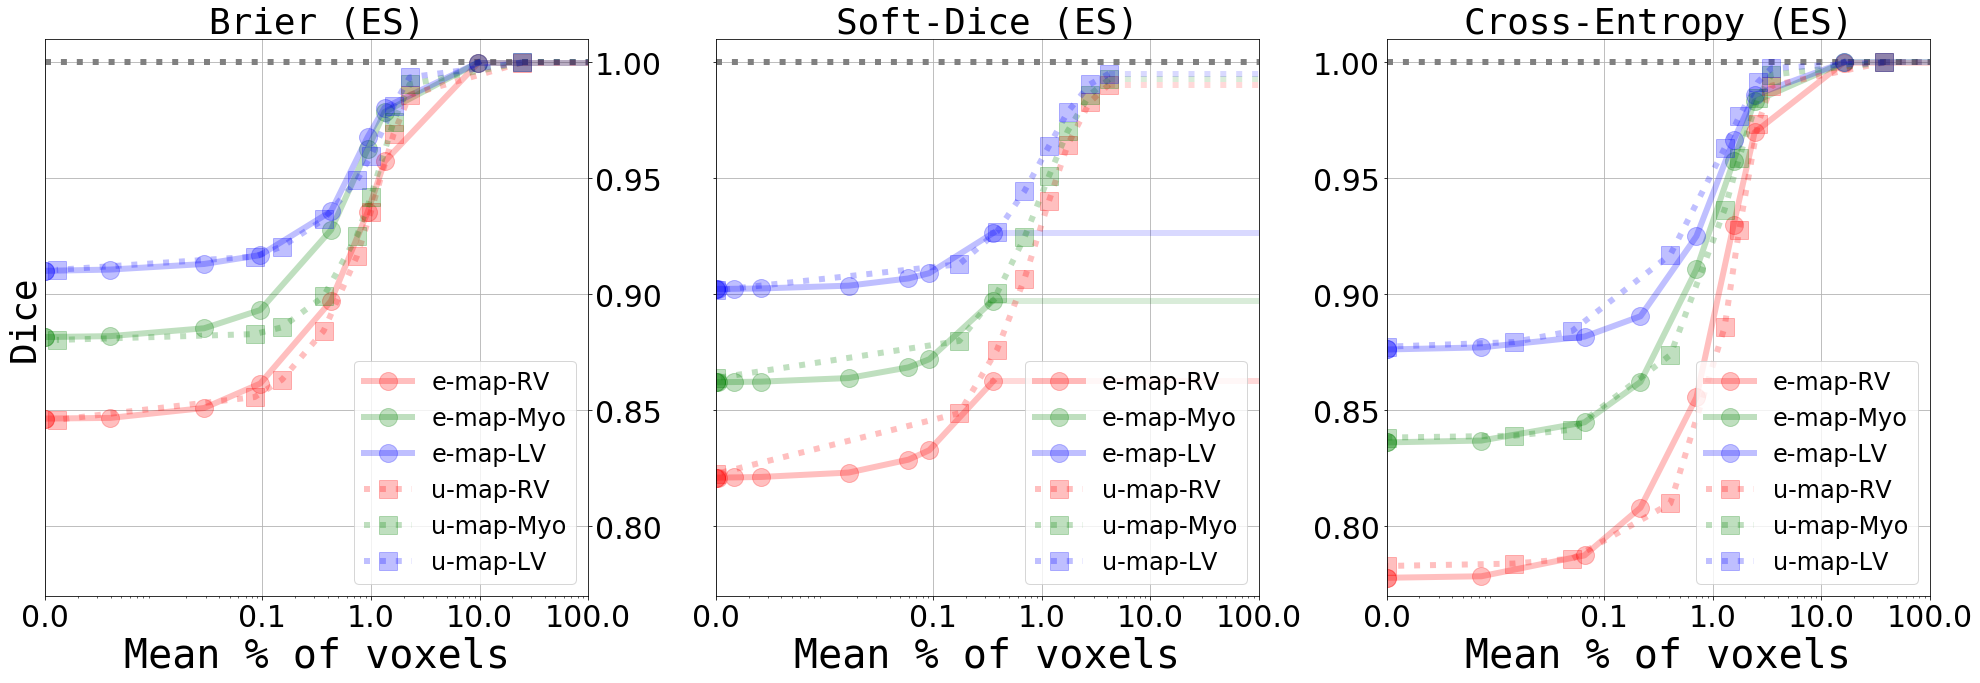

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/compare_maps_alosses_ED_perc.jpeg


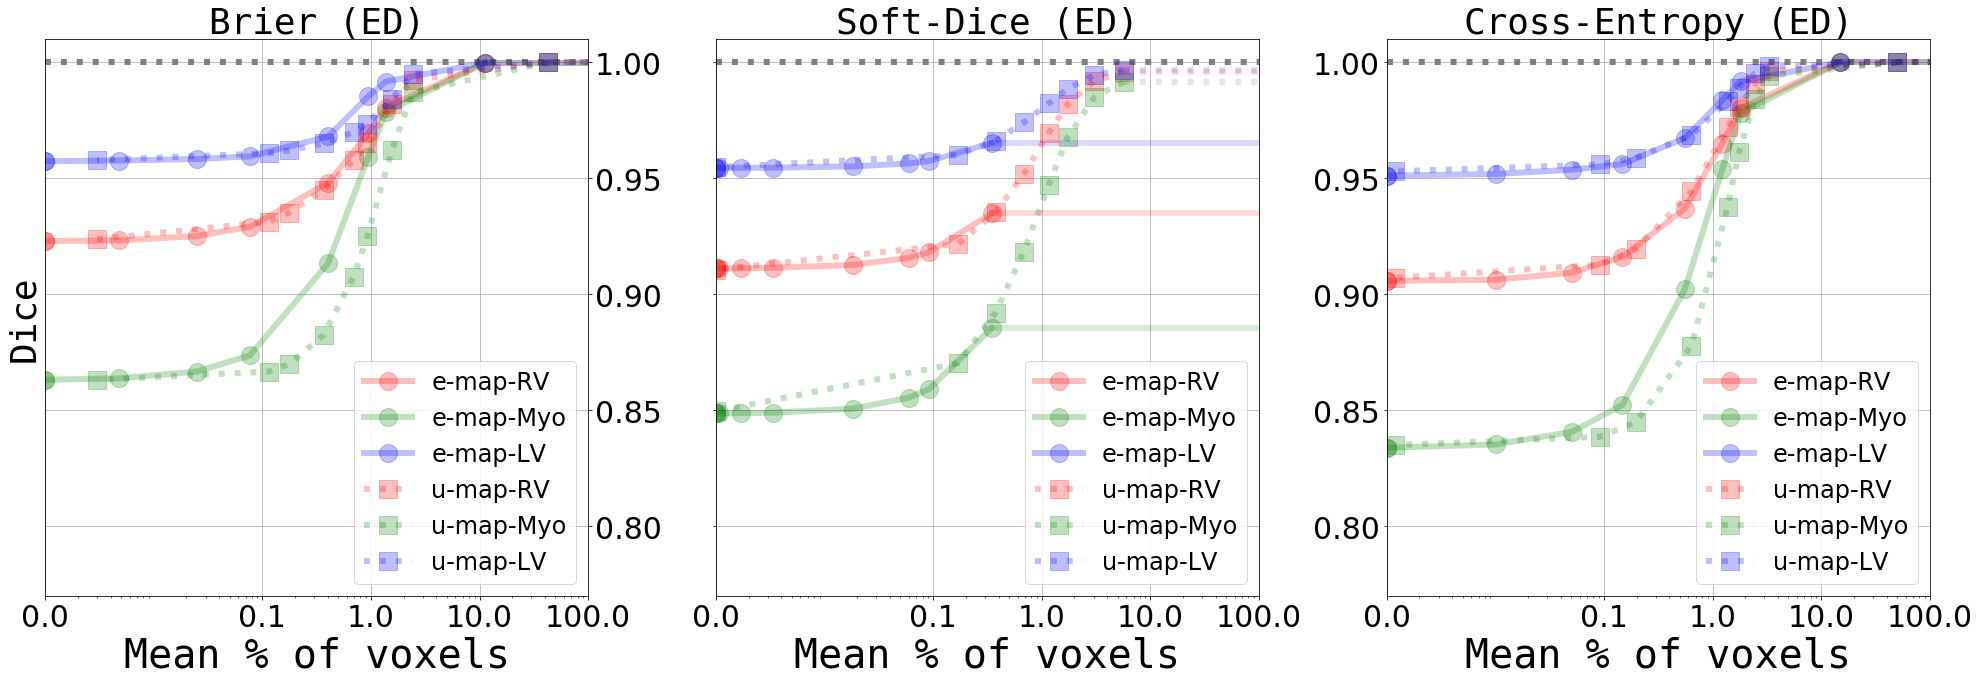

In [21]:
from plotting.compare_ref_results import compare_referral_results_v2

loss_type = 3  #  1="cross-entropy"  2="brier"     3="soft-dice"

if plot_type == "perc":
    x_range=[1e-3, 100]
else:
    x_range = None

ref_result_objects = [ref_res_mcbrier_ep, ref_res_mcbrier_um, 
                      ref_res_mcsoftdice_ep, ref_res_mcsoftdice_um,
                      ref_res_mccrossent_ep, ref_res_mccrossent_um]



compare_referral_results_v2(ref_result_objects, width=30, height=19, plot_base=False, plot_type=plot_type,
                             do_save=True, do_show=True, plot_title=None, x_range=x_range,
                             fig_name="compare_maps_alosses")

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/compare_maps_Soft-Dice_perc.jpeg


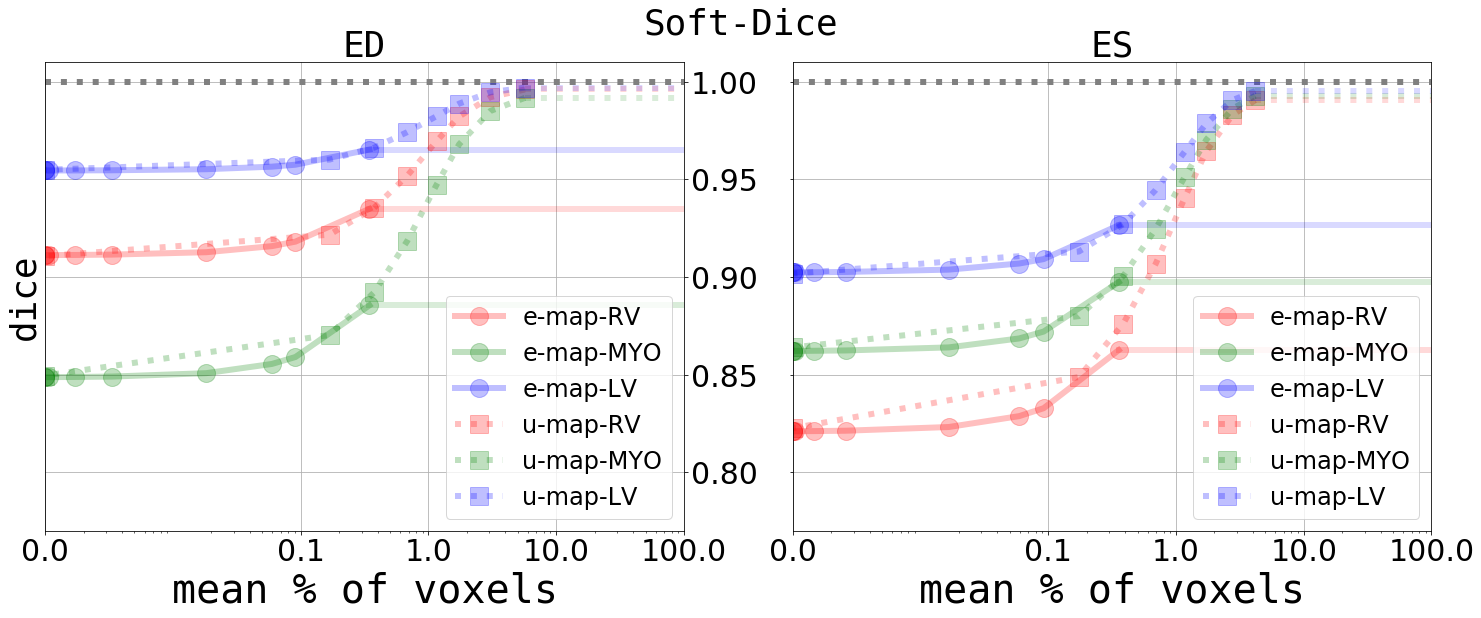

In [20]:
from plotting.compare_ref_results import compare_referral_results

loss_type = 3  #  1="cross-entropy"  2="brier"     3="soft-dice"
plot_type = "perc"

if plot_type == "perc":
    x_range=[1e-3, 100]
else:
    x_range = None

if loss_type == 3:
    ref_result_objects = [ref_res_mcsoftdice_ep, ref_res_mcsoftdice_um]
    exper_hdl = exper_hdl_mc01_softdice
elif loss_type == 2:
    ref_result_objects = [ref_res_mcbrier_ep, ref_res_mcbrier_um]
    exper_hdl = exper_hdl_mc01_brier
elif loss_type == 1:
    ref_result_objects = [ref_res_mccrossent_ep, ref_res_mccrossent_um]
    exper_hdl = exper_hdl_mc01_crossent
else:
    raise ValueError("ERROR - {} is not a valid loss type".format(loss_type))

plot_title = "{}".format(exper_hdl.exper.run_args.loss_function.title())
compare_referral_results(ref_result_objects, width=22, height=16, plot_base=False, plot_type=plot_type,
                             do_save=True, do_show=True, plot_title=plot_title, x_range=x_range,
                             fig_name="compare_maps_{}".format(exper_hdl.exper.run_args.loss_function.title()))

### Generate data for calibration plots (based on predictions and ground truth)

In [3]:
from plotting.calibration_plots import compute_calibration_terms

# exper_hdl_mc01_brier, exper_hdl_base, exper_hdl_base_brier   exper_hdl_mc01_softmax
# exp_base    exp_base_brier   exp_mc01_brier   exp_mc01_softmax  exp_mc01_crossent

with_bg = False

prob_bins, acc_bins, mean_ece_per_class = compute_calibration_terms(exp_mc01_crossent, patient_id=None, 
                                                                    mc_dropout=False, do_save=True,
                                                                    force_reload=False, num_of_bins=10,
                                                                    with_bg=with_bg)


INFO - WITH background class
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_09_33_dcnn_mc_f0p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_13_51_dcnn_mc_f1p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_11_10_dcnn_mc_f2p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180703_18_15_22_dcnn_mc_f3p01_entrpy_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=cross-entropy


  4%|▍         | 1/25 [00:00<00:02,  8.38it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 12.84it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=cross-entropy


  4%|▍         | 1/25 [00:00<00:03,  7.48it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 11.49it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=cross-entropy


  0%|          | 0/25 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 12.31it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=cross-entropy


  4%|▍         | 1/25 [00:00<00:03,  6.49it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 11.81it/s]


INFO - Successfully loaded 25 ED/ES patient pairs


### Load data in order to generate calibration plots

In [30]:
from plotting.calibration_plots import CalibrationData

loss_function = 3  # 1=cross-entropy    2="brier"   3="soft-dice" 
with_bg = False

if loss_function == 1:
    exper_hdl = exper_hdl_mc01_crossent
elif loss_function == 2:
    exper_hdl = exper_hdl_mc01_brier
elif loss_function == 3:
    exper_hdl = exper_hdl_mc01_softdice
else:
    raise ValueError("ERROR")

model_cal_data = CalibrationData("dcnn_mc", exper_hdl.exper.run_args.loss_function, with_bg=with_bg)
model_cal_data.load()

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/dcnn_mc_soft-dice_reliability_probs.jpeg


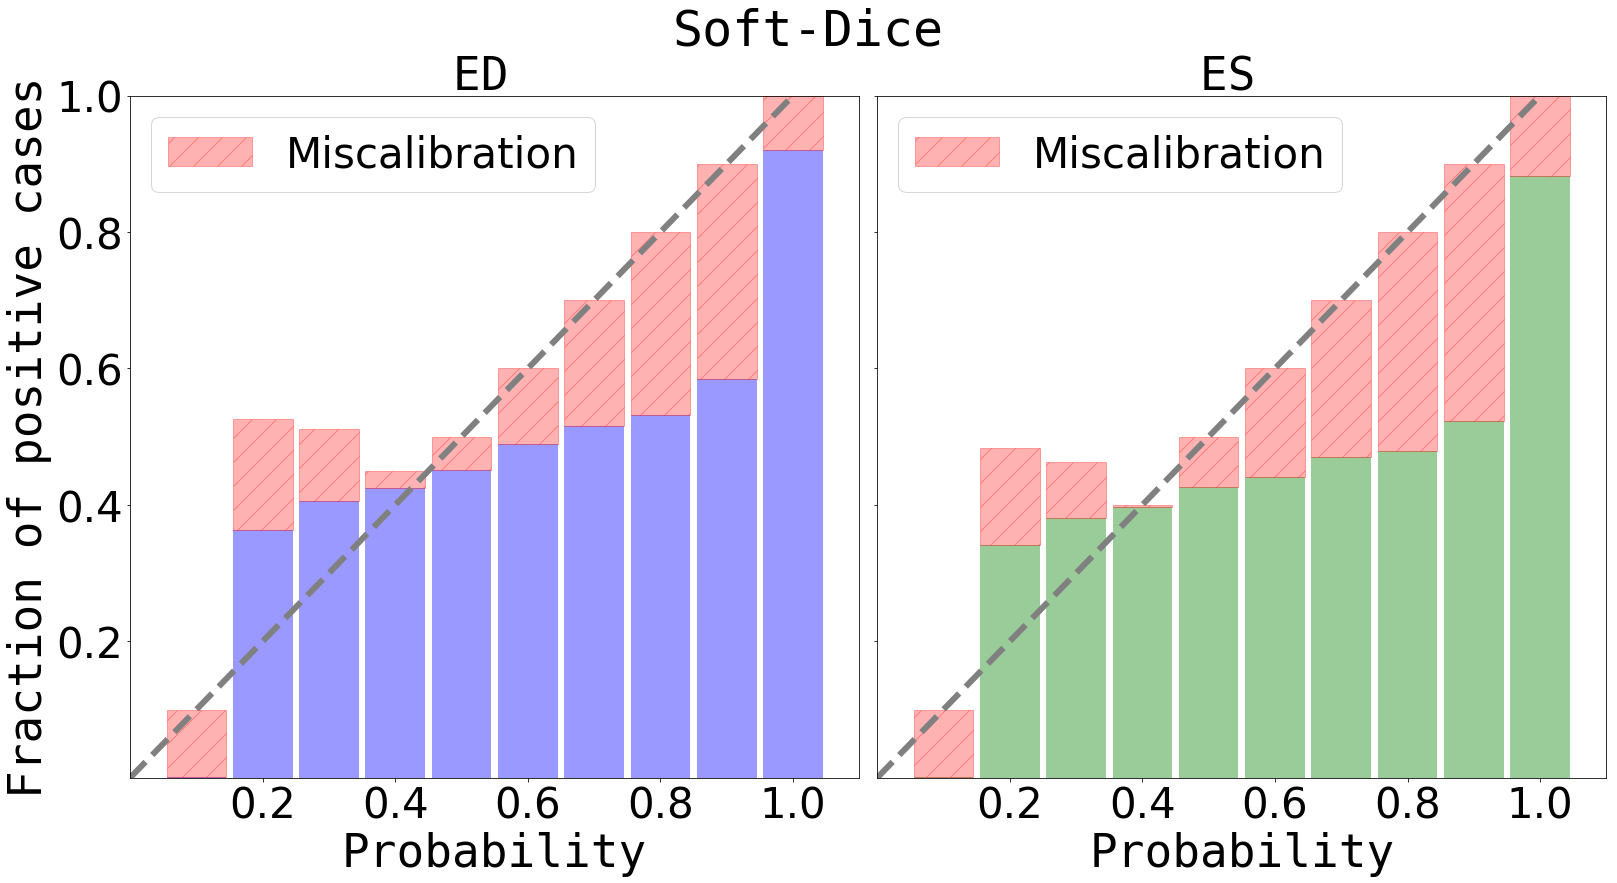

In [31]:
from plotting.calibration_plots import plot_reliability_diagram, CalibrationData, plot_loss_functions_for_true_label

plot_reliability_diagram(model_cal_data, do_save=True, per_class=False, width=24, height=23)

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/compare_loss_functions.jpeg


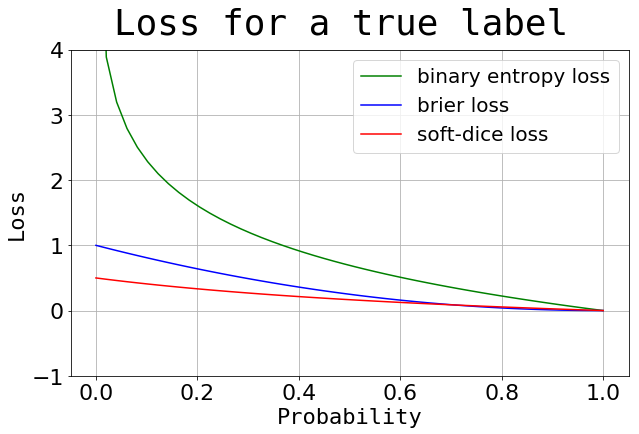

In [14]:
plot_loss_functions_for_true_label(do_show=True, do_save=True, width=10, height=6)